In [2]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
import base64
from io import BytesIO
from PIL import Image

%matplotlib inline

In [3]:
images_dir = os.path.join('data', 'images')
faces_dir = os.path.join(images_dir, 'train', 'faces')
with_mask_dir = 'with_mask'
batch_size = 32
img_height = 256
img_width = 256
autotune = tf.data.experimental.AUTOTUNE

In [77]:
def generate_images(path):
    global frames
    label = path.split(os.path.sep)[-2]
    cam = cv2.VideoCapture(path) 
    success = True
    while(success): 
        success, frame = cam.read() 
        if success:
            frames += 1
            if frames % frame_instance == 0:
                name = os.path.join(images_dir, 'train', label, label + str(frames // frame_instance) + '.jpg')
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) if 'rotate' in path else frame
                cv2.imwrite(name, cv2.resize(frame, (img_height, img_width)))
    cam.release() 
    cv2.destroyAllWindows()
    print('Generated images for path "{}"'.format(path))

frames = 0
frame_instance = 1
videos_path = os.path.join('data', 'videos') + os.path.sep + '*' + os.path.sep + '*.mp4'
results = [generate_images(path) for path in glob.glob(videos_path)]
print('Total images generated: ', frames // frame_instance)

Generated images for path "data\videos\without_mask\VID-20201106-WA0001rotate.mp4"
Generated images for path "data\videos\without_mask\VID-20201110-WA0004.mp4"
Generated images for path "data\videos\without_mask\VID-20201115-WA0002.mp4"
Generated images for path "data\videos\without_mask\WIN_20201115_20_44_52_Pro.mp4"
Generated images for path "data\videos\with_mask\VID-20201106-WA0000rotate.mp4"
Generated images for path "data\videos\with_mask\VID-20201110-WA0005.mp4"
Generated images for path "data\videos\with_mask\VID-20201115-WA0001.mp4"
Generated images for path "data\videos\with_mask\WIN_20201115_20_45_35_Pro.mp4"
Total images generated:  5068


In [78]:
%%time
try:  
    os.mkdir(faces_dir)
    os.mkdir(os.path.join(faces_dir, 'with_mask'))
    os.mkdir(os.path.join(faces_dir, 'without_mask'))
except OSError as error:  
    print(error)

def extract_face(filename):
    global faces
    label = filename.split(os.path.sep)[-2]
    pixels = cv2.imread(filename)
    classifier = cv2.CascadeClassifier(os.path.join('model', 'haarcascade_frontalface_default.xml'))
    bboxes = classifier.detectMultiScale(pixels)
    try:
        x, y, width, height = bboxes[0]
        face = pixels[y: y + height, x: x + width]
        name = os.path.join(faces_dir, label, filename.split(os.path.sep)[-1])
        cv2.imwrite(name, cv2.resize(face, (img_height, img_width)))
        cv2.destroyAllWindows()
        faces[label] += 1
    except:
        cv2.destroyAllWindows()

faces = {'with_mask': 0, 'without_mask': 0}
images_path = os.path.join(images_dir, 'train') + os.path.sep + '*' + os.path.sep + '*.jpg'
results = [extract_face(path) for path in glob.glob(images_path)]
print('Total faces generated: ', faces)

Total faces generated:  {'with_mask': 559, 'without_mask': 2209}
Wall time: 3min 39s


In [87]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(faces_dir),
  validation_split=0.2,
  subset='training',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(faces_dir),
  validation_split=0.2,
  subset='validation',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2768 files belonging to 2 classes.
Using 2215 files for training.
Found 2768 files belonging to 2 classes.
Using 553 files for validation.


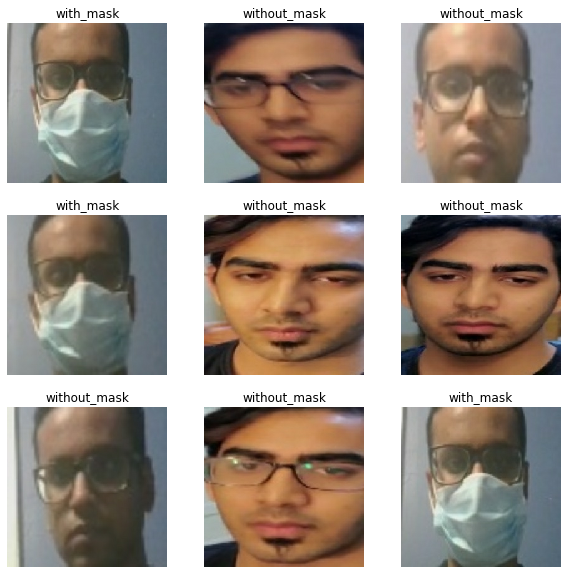

In [88]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

In [89]:
train_dataset = train_dataset.cache().prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=autotune)

In [90]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)             

In [91]:
num_epochs = 2
history = model.fit(train_dataset, epochs=num_epochs, validation_data=validation_dataset)

Epoch 1/2
70/70 [==============================] - 65s 924ms/step - loss: 1.4038 - acc: 0.9088 - val_loss: 0.0925 - val_acc: 0.9892
Epoch 2/2
70/70 [==============================] - 61s 869ms/step - loss: 0.0704 - acc: 0.9874 - val_loss: 0.0556 - val_acc: 0.9892


In [92]:
test_dir = os.path.join(images_dir, 'test')
file_names = os.listdir(test_dir)
for file_name in file_names:
    pixels = cv2.resize(cv2.imread(os.path.join(test_dir, file_name)), (img_height, img_width))
    classifier = cv2.CascadeClassifier(os.path.join('model', 'haarcascade_frontalface_default.xml'))
    bboxes = classifier.detectMultiScale(pixels)
    try:
        x, y, width, height = bboxes[0]
        face = pixels[y: y + height, x: x + width]
    except:
        face = pixels
    img = cv2.resize(face, (img_height, img_width))
#     cv2.imshow('face detection', img)
#     cv2.waitKey(0)
    img = np.expand_dims(np.asarray(img), axis=0)
    img = np.vstack([img])
    result = model.predict(img)[0]
    print(file_name + ' is ' + ('with mask' if result > 0.5 else 'without mask'))

with-mask-default-mask-seed0000.png is with mask
with-mask-default-mask-seed0001.png is with mask
without_mask1.jpg is with mask
without_mask2.jpg is with mask
without_mask225.jpg is with mask
without_mask3.jpg is without mask
without_mask4.jpg is without mask
without_mask5.jpg is without mask
without_mask6.jpg is without mask
with_mask1.jpg is with mask
with_mask2.jpg is with mask
with_mask3.jpg is without mask
with_mask4.jpg is without mask
with_mask5.jpg is with mask


In [93]:
model_json = model.to_json()
with open(os.path.join('model', 'model.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join('model', 'model.h5'))
print('Saved model to disk')

Saved model to disk


In [21]:
def predict_base64(img_str):
    pixels = cv2.imdecode(np.frombuffer(base64.b64decode(img_str), dtype=np.uint8), 1)
    classifier = cv2.CascadeClassifier(os.path.join('model', 'haarcascade_frontalface_default.xml'))
    bboxes = classifier.detectMultiScale(pixels)
    try:
        x, y, width, height = bboxes[0]
        face = pixels[y: y + height, x: x + width]
    except:
        face = pixels
    img = cv2.resize(face, (img_height, img_width))
    img = np.expand_dims(np.asarray(img), axis=0)
    img = np.vstack([img])
    result = model.predict(img)[0]
    print('with mask' if result > 0.5 else 'without mask')

In [22]:
predict_base64('/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTEhIWFhUXFRgYGBgVFRcYGBUVGBUXFxUVFhUYHSggGholGxYVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGi0lHyUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOEA4QMBEQACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAwQFBgcCAQj/xABKEAABAgQCBgYIAwUECQUAAAABAAIDBBEhBTEGEkFRYXEigZGhscETMjRCc7PR8AcjUhQzYnLhdJKy8VNjgoOToqPCwxUWJENU/8QAGwEAAgMBAQEAAAAAAAAAAAAAAAIBAwQGBQf/xAA3EQACAQIEAwYFAwQBBQAAAAAAAQIDEQQSITFBUbEFEyIzYXEyUnKBkRRCoTTB0fAjBlNi4fH/2gAMAwEAAhEDEQA/ANxQAIAEAYQw2HJdUzhU9DpQMCCAUgeqABAAgDxzgLmgQ2lqyYpydkiAxrSiHC6LKPdt/SOvavPxGPjDww1f8Hq4TsqdRZqnhX8lOnsfmYrq+lcwbmEtA7DfrXmTxVabu5Ne2h7dLA0Kasop+6uJNxGP/p4p/wB4/wCqTv6vzP8ALLf0tD5I/hHYxKP/AKeL/wAR/wBUd/V+Z/lh+mofJH8L/ArDno5/+6KeUR/1Ud/V+Z/lh+mofJH8I7M5Hp++i/8AEfbvR39X5n+WH6ah/wBuP4RxL4nG1gDGi3/1jvqjvqvzP8sj9NQ+SP4RIQJ2LasWJUZ9N31R39X5n+WT+lofJH8IlZDG3tNHXGV63ptBWmjj5wfid16mPEdmUqi8Ks/QscpNsiCrew5r2KNeFVXic9iMLUoO0tuYurjOCkRs8QFwQTc2TR72WX+BC+W1c3iPNl7vqdlhPIh9K6EgqTQCABAAgAQAIAwdmQ5LqmcItjtA4IFBAAgD1AHEaKGtLnGgAqSdgSykoq7GhBzkordlAx/SR8UlrDRnA58SV4OJxcqrstEdXg+z6dBZt5EBSuaxnoHYYgLCsOWJQSL/ALIBme8IA5e1ou3P75oICDHdVQCFIsEazSNvdvQTYfSjPr3IJPdW5N0EDuUnSw1B708KkoO8WV1aUakcskWrDsQbEGYr4r3sNilVWu5yuNwToS02Hq2HnM8QCBBJsmj3ssv8CF8tq5vEebL3fU7LCeRD6V0JBUmgEACABAAgAQBg7MhyXVM4RbHaBwQKCABAA9wAJJoAKknYBmobSV2NGLk7LczzSbH3R3ajCRCB5a5HvHhuC8DF4t1XlXw9TqcBgI0I5payf8eiINjFiPSO7IJOXRgP6KQuKQZk7vNBFx2wB2Y8VFybCoww1sDTtRcnKTEDBXaoNMz/AJpHIdRF42BuoLZeajMGU6GEvDclOYMpHzEq4WpTqTJiOI0dDPM8j9FJFglZ10N18toNusKyE8rKqtNTVi94bONisBBvt+vWuiw9VVIX4nHYzDyo1GntwHSvMyBBJsmj3ssv8CF8tq5vEebL3fU7LCeRD6V0JBUmgEACABAAgAQBg7MhyXVM4RbHaBwQKCABAFR02xQ2gNNs3+QXkdoV3fu19zoOyMKrd9JexT6Lyj3jxz9gQBwGl1ggUmcNwJz9iRzsWRptlwwvQ5hHSaqnVL40Sbg6Hwx7tQkzsdU0O4OjTW5BGZk5ESsLCWigpxU3FsP/AP01m4I0A7GGs1aav0UoixCYno2wtNr8FOwaMo2KYA5pNG27D2JlMSUCvzEGlj4V8lYmVONhTAsS9DEofVJpnkDn98FrwuIdKfoedjsIq9NrjwL6DuXRp3OQs07MEAbJo97LL/AhfLaubxHmy931OywnkQ+ldCQVJoBAAgAQAIAEAYOzIcl1TOEWx2gcECggBKbjBjHPPugn6KupPJBy5FtGn3lRQXFmWz0cve5xvUrmZycpNs7WnBQiorZDat6b0o9ztsLZ9/5KASuWDB8KrQkKuUi+EC+YPIhtFnlI0xjYtEtCACgkfQ2prECzWKSGevbkgVCrGKbBccQ2CiZCtu5xFhWQQV3EZIOOdDySMcpOPYMbu1esfWieMhJRKXOw21pUhw/V9VcmZ5IsuiU+XAw3G4FQN17r2+zqzacGc32xh1FqovuWJemeIbJo97LL/AhfLaubxHmy931OywnkQ+ldCQVJoBAAgAQAIAEAYOzIcl1TOEWx2gcECggCH0ri6ss7iQO/+iw9oStRfqel2VDNiE+SZnUVeCdUcwbVPBBKLBo7hfpHVOSqqSsXU4XL7J4cG5ABZXK5rUbExLQqJRyTgp0Kx5CcpQrQ6hpxGKUUgKUUkIUY2ilCsIihghtEgA7FFhrjDE5JrmkcEWBGKaWSZhxHDcbV+7hWwZRUWo30TjfntoabCOYp2ZLfgpWqo8rtKGbDyNBXQnImyaPeyy/wIXy2rm8R5svd9Ts8J5EPpXQkFSaAQAIAEACABAGDsyHJdUzhFsdoHBAoIArumz/ymje4nsH9V5nab8EV6ntdix/5JP0KE9eMdEeyrC5wG8qHoSldmkaPS2q0LHUkb6cdC2SrFUXDxkNNYi44hO2KUKx5AToVjxoTCHQUkHdVICoU2FCiLBc8cFAXGkcWUDGWfiNKgHW2/dk8NyqpsUzAYf57CDtAPC+xbKD/AORe5gxS/wCKXsaOumOJNk0e9ll/gQvltXN4jzZe76nZ4TyIfSuhIKk0AgAQAIAEACAMHZkOS6pnCLY7QOCBQQBVNOY1mM2ip7bDwK8ftOd5RidD2LTajKfPT8FKjm3NeWe2SmjcrrP1jsSVHZFtJXZfJN4AWR6m2LsTEtjcFlnPChRZLkh7/wC4penrhPlYuZcxaFikF1CIje0KMpN0SMCaFBRwI4FSToyRhxBRNcRo7LkXIsJxZ1rbuNBxU3DKRkXS6Waaa9eQJTJsVxEhpxArQB3YpuJYeQdJYbsw5v8AMKDtyUNjKI7EYOFQQa7kpLKN+JMOkLWpwKeG4k9jNcAifnwzW2uK9u1bMPbvY35o83FXdGduTNJXTHFmyaPeyy/wIXy2rm8R5svd9TssJ5EPpXQkFSaAQAIAEACABAGEMyHJdUzhUjpA4IEBAFB0tj60dw/TQd11zuNlmry9NDr+zaeXDR9dSsRnLMbC2aLw6QweKoqvU00diaMN8V2o2zfePkFVtqX7k7IYXAZYsBPJVubLFFC8fDJUi4p3bvqmUpENRGUfRaGT+W+h5g9u1MqjFdOLO5bDY0uRU1G+viFDlcmMbFswuZLhmli9R2iZEOyssVXIDGsP9IbuskY62IxmGSrD0r9p3Z9ynMyMqJSS/ZRcMFNp1a7r1vvUq4rsSMSUgRG2a2m9tvBNoRqiJMkZaI10Mkw3Gjm1JpXbcoB7Eb+JXsjjxCeO5XP4TJsBoI7N2sCeVRVaqbtOLfNGCtFypyS5PoaeupOHNk0e9ll/gQvltXNYjzZe76nZ4TyIfSuhIKk0AgAQAIAEACAMIh5DkuqZwsTpA4IEBQSZfisXWiPdve4965Wcs02/U7qlHLTjH0RFRRdCBouujLPygs9Tc10tixwTqhU3L0QOL4vGLtSDUH9X0V1OC3ZTUnJaIisQlogcQ6KahtXEmgrqk0HUKDiVbdJ2RRq1dly0Nw+LMMtMMe7UL2tfegFAWvNA5pNbEE5HOylRjJPmTnlFrkSDZ55huY6oc06rmuuWHdXaNxWSUbOxsi7q490Ymb0KS1mWXui7gjUCu4FHErGksd8NpIrzGfVxSyjrYaDvqUjHJeMYLHOiFuu+lG1o1udXEXJts71akooqk5N2IXApH0haPTRNYxms1QXglpcRr1rS1jSh9ZWxackiiV0m7Fsd+1yUwGFxiw7DWAGsWnY8ZE8fBV1IpMtpSk1fgXqVeIjAd6rTLGin/iq6ksGja/wFVZDcqqfCZThpo9p3q2WxngtTUmuqAd4quqhLNFPmcNUjlm4vg2bLo97LL/AhfLaudxHmy931OvwnkQ+ldCQVJoBAAgAQAIAEAYQzIcl1TOFidIHBAgjPRNWG87mnwVNeWWlJ+howlPPWjH1MvnBR1Fy6O3ZNxcAhlmrD/etArX3iVXGo73L5UVl03JHRdp9HQihDiOtRV3Jo7FnMlVts1muabEVM4IWnWGf3sVsZ2K5QuKnB/TULm9KlKtNKjc4EEFWOSYmQn9H5R0s12o1oqQC49J1BWlKUaEKdlZB3SbuxKZl2h5frOLiCHAgUIN8htqqpXkWqyQ+0ewuIHaxGqONj2J1SlJ3KpYiMFYvsTDnBooQeGSudF8DOsQnuQuLSlW3ravfwVUk73NFOa2KvNYUSzU1atzAOddhDs1Ck1uPKMWdYPo6ITg9oAiAkNLr6tRWobYcK53TwaWpXNJ6MnYGCtLi+JVzjv3bKbiolZgm0PoMuGC10lrDXuVnS3DP2l8GFWjQXOdyGqPNWRdtSuSu0ig6WYbAhTEP0DaDVvuJBpUd6ISvcKsEmrFikjWGz+ULqcHLNQi/Q4XtGGTFTXr11Nq0e9ll/gQvltXiYjzZe76nTYTyIfSuhIKk0AgAQAIAEACAMIh5DkuqZwsTpA4IEGGOupAf1DtcFi7QdsPL7dT0uyYp4qN/XoZ1PH8zlRc8tjreJbsLGs8uG1ocD1LK9Dfo1cmoUhSIS1tQ8h4p/EL94KeV5bFMGo7low7CIrqVo0cT9KpY0JMmWJgtiYZo6D6zx/d/qrlhubKXi+SHMHR+C3NxPZ97D2JlhooT9XJizsMhDeev6BN3MRf1EmRsWXY01Y0C5vme03RkihHUk92LyT2h3ScOWfcroxbKZTS3LU2KCM+1NZkZkePhNdZzQUjSe48ZNbCTcMgj3e931S93HkWd9LmdtkIQ93vcju48g72XM9MlD3d5R3ceQd7LmN40gwixI7/FQ6MWSsRJFW0kkHNZEiB12wy2osauc0+AVVSm4QbL6NVVaiRlWkhHpWMrV0OG0O5m9PBVUVaJoxTTnZcCfw/8Adt++K6Tsueahbk3/AJOL7bhlxV+aT/sbZo97LL/AhfLavMxHmy931PbwnkQ+ldCQVJoBAAgAQAIAEAYRDyHJdUzhYnSBwQIRmkL6QqfqcB2X8l53acrUbc2v8nr9iwcsRm5J/wCCgxxWIV4J1KLLorMdBzT7otyJyVFRcTVRd1YuGBTxdBiwTTo6r2HgSQR1F1etaKD0sZMVHW5bpWMAKl17Wrxv5q9JmZyS3JWBMtOwm36eB38K9qbKxM64Cjpvcw9rR5qcnqR3noN5icdSzQOZJ8AjIuZHeS4Ir09OH3ndTR2plT5IR1eb/A80fh6xq0WrtUtWWosXd+FFw2JEXPY5Y/cUNEJi4iclFh8welPDvRYMzD0h3BFkF2Jvi8EZSMxXNJJrUgxn0Jo2tLXoxxy6gkxHwJF2Dv3rfoYHLRXRHRHuNXOdrHmVRa2hpu3dsu+GD8tvLyXr9jy8M4+qOd/6gj4qcvR/2Nu0e9ll/gQvltWPEebL3fU9LCeRD6V0JBUmgEACABAAgAQBg7MhyXVM4RbHaBwQKQOkz7tG4F3kPNeJ2rLxRj9zpOw4WpznzaX4/wDpSnO6RK8o90mNF4o9K5pyc3wKSotC2k7SLng8AsjH9JhnxBp3KcO7ysRi42hctEjNtyoQa7dvYttnzPMzLkTcs/o8T9/VMkI2LNYaXce1TmFyt8SGxeOSdUFPCxVVTWlxFuHa5FbJ3LQRQ1LJhcvqCgVT1NEbomIT9irsXXEogoU62K3oxVjkrGR0RVAAQgkaTLyAnik2Vzk0tCmfiNO6kjGO0sLRxLqADvVGISvFGvByeWUjHsLPrcq94VDNES7YS6sIcD5L0OyZWqyjzXRnj9vQvQhLk+qNu0e9ll/gQvltVWI82Xu+ppwnkQ+ldCQVJoBAAgAQAIAEAYOzIcl1TOEWx2gcEClZ0mf0ncGgeJ81zvaUr1/ZI63seNsKvVt/2KgVhPVPIM2YcRr25tpbfvCnLdWIzWdzU9EJlsyDFaDqt6JqDZ9jTsv1qcPRak2LjMRFwSJWYJDhvp4Lc4aHlqtroWGBVrGnbQVHFIWWVjv9tNKEVOwBRuxlotTmWkQOk81cd+xNdvYrypasdGGdgRYm9yXlIdGiuaW46R0wmqaxF9RxmEuw1ribWEJm7iJNCoISj3PUEjWfbavEeKeG5VV0VzKfxjEcQ2M1fyXEVcP1j3Tu3jf1LPWTz5jXhpLusq34mf4S383V327QqJbGiO5dsH/dEcQtPZ0suJXrdfwYe14ZsHL0s/5Nu0e9ll/gQvltT4jzZ+76kYT+nh9K6EgqTQCABAAgAQAIAwdmQ5LqmcItjtA4IFKXjsWrn/zEdlvJcniJudWTfM7vCU1TowiuSK89Vl41im6dbCM3X8KsO9Hh7Cc4rnRTfYSGs2/oZVaoRtE8+rK82iTxAs9M3XIAaPeIF+tWatFGilqxtPYu3JgLz/CLf3jZNGlzFlXWyI2Fi8dtSYIHEHWPkrVRg92Z5YmpHZaHcaejmhMQiuwADyql8K0sM1N2bl9i36PNd6IFxJJNbmqona5tp3S1JVxtYntS2HbEobidp7U1iBRkQ1z70rRKuOoz2gAk0Qk3sTJpbjR04zY4dqfIyrvI8zhuI8CeV1PdkKqcxsTY4FpbEBP+rfTtATRpNa6fkrniItZWn+GMsZlIUzLxIEYEBzaV1fVObXiu0GhSVKd0WUari1oYBK9GNYggEdIZEVzHArA9j1luXXDD0Xc6d5UUKnd1oy5MTF0+8oThzTNu0e9ll/gQvltWzEebP3fUx4TyIfSuhIKk0AgAQAIAEACAMHZkOS6pnCLY7QOFVDdlchRzNLmUDE4lTzJK45u7ufQVHKkiKepQDUNVgljZ9BvQmTgAPY9zYdHAEFzXEuJaadIUrwW6m3kSR5NaK71t7knikBj2karbvsaAnZrX3daujJx1MtSCqJJcxwIPQrYUCrzXZfksiOmG1VqdjO1mYtJy+s4NNwqZSNUIF1lwABbYkL0LOpuUEjWtNiYWx3CclYyY5i0IBIrb7opjoLOzPYEMbvJDZEEhcsFUt2PZCcVwbU50ClXYsmkZ9+ImkTYEF0Frqx4rCKD3Gus55Oy2sBx5IrzUY5eLJw1Jylmey6mRy7ankFiPTsXXBzVhO93kFT+4ap8Buej3ssv8CF8tq9Cu71Ze76nnYVWoQX/iuhIKovBAAgAQAIAEAYOzIcl1TOEWx2gcSmX0Y47mnwVOInkpSl6MuwkM9eEfVFEnx4Lk47Hdy3IyOFKIYgRmmIF8PxOJAdVtxmWnI/Q8Qr6VaVPYyYjDQrLxb8GaXgs698NkVj6sIs0kkg7QdxBrluXoZ4VIXPIVGrQq2vdFolZ9jmar+ieOR5H6rNZ30NzacdT18vS4uPvarFJ8SlwXAeYQzpVooexMXqWOGxIXIVJ4KCRN7EXCwmEMkdNFkXBoXZDoOKhsElYTfHa3M33ZpsrYrlFbkBpJjAhQIkd/RYxtSK3ccms5l1BQb1ZpBXZRaVWSUTA5mfiTEV8WKavedY7huaOAFAOAXnTk27s9mEVFWRzBdR1P4Uoxc8HtCb1Htqqo6yGqaQubro/7LL/AhfLavQrK1SS9X1PPw0s1GD9F0JBVFwIAEACABAAgDB2ZDkuqZwi2O0DiM5+7f/K7wKz4ryZ+z6GjBf1FP6l1KTPC65Tgdy9yNiC9FKIY3pbme5MQNoouE6Fe5PaFY36KL6F5/LiG38EQ2B4A2B6jsVtOeV3M1annVjUmtFOBsfvetNk9THdxVmduhub0mOLevyS3sMlfUdYTizmvo9rbkUdcX3HYrUlJFEpOEvQtv7bYdEdRVeQv7zQctmQfd70riOpHL5sZFnejKDn6Hoc0itD3ItqF1YSE5+ltRtJNB/VPk5lbq8kEWO92ZoNzbV81KSREpNjZ8RoaXOIa0AkkmgaALkk+KZu2rK4q7sjFvxD0pM470cKol4buiMjEdtiOHXQDYOJthqVcz9D1KNBU4+pV5TZyVLNCHsKHV4HBRwJ4luwR9tXcRTle3iiir1I25oTESSpSb5M3bR72WX+BC+W1bcR5s/d9TDhP6eH0roSCpNAIAEACABAAgDB2ZDkuqZwi2O0FgjOtrDeP4T4LPi45qE16M0YCWXE02+aKRiL7rlbaHb8SO2E8EAESHRrRwqpCwymm3TxFkM4uadFcjWNG8a9LLw4jr+5E4OFtfrsetaaMuBixUdMxZYkcUBzB2jIqzIU95oJVBBGqSrIwZTOorNErLYr0A11QQKXBvTmrJU+JTTrq1mS0lONpXW8PFVShqaIVFbcWjxdoySZSxz5CrYlQKivDZ1pkrCuV9BUu2AX7goJudughoJefqVF77EuNtzJPxYxyK+PClmnVghhiOY33yDRuudoFK0yr1LHOtnvY9GjQyWct+hnpNa/zHyVPE0CksNihkol5SH0idwSjWLBhrbg8/C61YBXxMV/uxh7UlbCz9v7m8aPeyy/wIXy2q3EebL3fUqwnkQ+ldCQVJoBAAgAQAIAEAYOzIcl1TOEWx2gcEClDx+DqRXNGVbcjceK5fEUu7qygjtsJX72hGb3tr7kc3J3UszWpsTFHGpaP4QgkbTkHLrUxFZGTI8VYiqRc9AY4EMtd6riQeB2FRnyTuS6XeU7FuD3wjbI5jMOHEL04vOjxqkXTY+kJ2C6z9Zh2Gms3nv7irdVsZ7Rer0H8aCM4cUOO0AgO/um6mLa3Qk0pfDIGa7RQscb5hoVtovW5nzTj4bNjuXmTSnSbS9DVI6epbCtdWd0P4E6N9OG3sSOmyyNdW3+xIQZzdRvEkF3UNipkrbmunJydl/7OI5zJr15niV51fEZlljsethsIovNLcxj8RI4M2Tt9G1o7SSqKWqNdbSRWoLLdvimYiHUnD8VDJRKy7SPDtUDFhw2FQVXrdlUM0nVfDY5/tvFZYqit3q/Y3HR72WX+BC+W1UYjzZ+76mzCeRD6V0JBUmgEACABAAgAQBg7MhyXVM4RbHaCwECEFpBgzop14dNagBBNK0yIO9eZjcHKpLPDfkez2d2hGjDuqm3BlVmJV7HUe0itjUWrsuvIq0pReqOgo14TXhaY3e4hwruoqbGi51EjVpXeixNxjOwahPFiSRYNDh+Wf5iqq25bR2LnAmbar8th3c1ZQxOTSRTicIp6xEpiE4XaNZp3ZherTrQnxPDrYepTe2g6wvHA2jYrNdo2OFaK619mZrpfEiSmMQl84I1eIJH/AC0VkYy/cZ6koP4Fb7iMOM113OeRsAt4kq3MltYzKm5b3ZNSMo+lWsENtM31cT/s2WCvjYR0vmfoethOzKk9Usq9dX+CZkpWlyaneQPAWC8qtiJVHrouR7+HwkKC01fNnU6LLNI2xMQ05hOM7fINFOvNWUvhK62siNhtvbJo+/NNYS46wuHapFvEqJBEsMhh5NzYePJbcL2fOt4paR6+x5uO7Up4fwx8UuXBe/8AgmQKLoaVKNKChHY5OtWnWm5zerNk0e9ll/gQvltXP4jzZe76nW4TyIfSuhIKk0AgAQAIAEACAMHZkOS6pnCLY7QOCBQQB49gIoQCDmDcHqUNJqzGjJxd07MruKaLB5rDcG8CCewryqvZl5Xg7Lke3Q7ZajarG75oqc5JvhOLYgoWnqPEHcvNqUZQk1JHt0sRCrFSizhjg5pSKDuWuasT+iDOhzNe9UVty+jsXKDLhyz3NIR5Itu0kckRm09CJRUlqKScAv8AWDTxLQfBaY4qpHZmWeEpy3RMSuDM2tb1VCuWOqmZ9mUG72JqTlGN9Vo6h5qqeIqVN2XU8JRpaxih8Ie9VGgWDUAIx21Chkoyz8U4IbEgPGdHg8QC1aMLBSlZmfFTcYpoqmDxNWOzWAcHOoaj9Vge0hezDC04zi7HiV8RUlSlZ2foXkQGjJrRTcBZegqNNaqK/COfliaz0c3+Wdq0pQIJNk0e9ll/gQvltXN4jzZe76nZYTyIfSuhIKk0AgAQAIAEACAMHZkOS6pnCLY7QWAgQEAeOcBc2HFRsSk3sQOMaUw4Vof5juB6I69vUstbFxhtqehh+zp1NZaL+Sr4pjsSYADw0AGvRHmViqV5VVZnqUMJCg7xuN4EOrCBnQohG8X7Fk5WkiY0Ti0bTcvHqo9mky94VEqsrRrTJaPCq1KSNJaGWuqExBYZSNXYmQjRJQk6EYuwKbEHTigBtFclGMi/EGcEaaDQejDaRwqbnyXp9nUXK7PN7Rq5bR4lb9INYFvukGvEL3U4vY8ezs0+JJTelsRobSE2pzJJ8FTVxMoW0KKfZsJN3kyYw7HWPHT6B7u3Yr4VLq7MdbCSg/DqiThRmu9VwdyIPgrE09jLKMo7o2fR72WX+BC+W1c5iPNl7vqdjhPIh9K6EgqTQCABAAgAQAIAwdmQ5LqmcItjokC5sOKh6Flr7DKZxaCwXeDwb0j3JHViiyGGqS4EBP6TxDaE0MG83d2ZDvWWeIl+1WPQpYCC1m7kBMzT3mr3OceJr2blkk5Sep6MIQirRVhnFFQkkroti7M5YEsBpDySjapWmlLKzPVhmJDDW6hdTJeZiqThOx6eGqZ4X4lxwiYoASsE4m+LLTBiVCrLT1jbqUQyRlU6EZKQSnQjFC9BAhMzbWNLnEADeouSkUnHdNmgObCuTUA+YV1DDVKz8K05lNbEU6K8T15Gfuhax1nkmtz17SuloYZQionO1sRKpNyEYztgAArQfVaJJRjZCwXFkc9rnPuLD/JedZznrwNatGGm48ESoFOretLehny2eoqGkEZgoycRL3PprQ4//Ak/7LA+UxeHW8yXu+p7VPSC9iYVY4IAEACABAAgD5ei6RveB6Maopzd9F0LrN7HMwwMYfHqRszFiPNXvc7mfJVyTe5qiox+FWEL8vvYq762LLaHkQUJqa/ddvNLxGS0EXNLj0WmlN2zjsVcrvYsiktxIyxr9L/0VeVlmdIROf3z80sVqM9j0hWiJj6Qmb0KZwjVjkl9mQpSpSzR+5dsMoWazTb7sV4lanKnLLI9mlUjUipRJ7CIlbArO0aEyY1CNnYoJuOoJToRjoRwBcprkWIrEtImQwaXKRyGy8zPcex+JGcQXGg2L1MH2e6njqbHmYvHZPBT3IWu0mw7yugp01FWWx4knKTu92Jvikq7REqKQB4oXAGo2bx9Tn1Kicm1cbK72EI0CtbGptcc6XVEqLHjOx1LS76gtFw7fspSl+tR3ckROpC1mO3QXtFSw7TcbzQVpwU5pIrWWWx9JaFOrh0kd8pLn/osXi1Xecn6s9uKtFImlWMCABAAgAQAIA+S5ZrnNGrDNhQkC2W8L3MzWiPGlFZm2xWWlXGhc4DOu/K2SlQmxJVILYcwIENlARrk76jbmQL7TtUqjbdiyrN7I6mQ2lWta0i2XCmZqVa6cUiqFSTeowjgk0JJVc48C+MtBtFZQhVTjYsi0xhFZe33S6xtamuL0O2Nr5K6KuJLQ9dCTOFiFIk8Ixl8I0rY71EqcKqy1ETGU6TzU37rgW7AcUDog1bE5jmvMxWAnSWZar/dz0cNjo1Hllo+vsaG1oLa5LBY23GExOsbtB6lKJsQWJYyTYfRLZsnRFSn8Q1q0PM/T6r2MH2dfx1PweRi+0P2U/yRkVoNA3rptXuqPBHkRbV7ngbU/exXpaA3oeOZrdFpuQTspq0rnvKqqO/hRKeXxMaRo5bEZwudl3Cg7qdqxTqNVUXqCcGPHxIjhSmxXucmZoxpx1CDLRDUkqIwle7YTqU1oOxCiUu45KzI7FOaF9EfR2h/sEn/AGWB8pq56v5svd9ToqXwL2RLqocEACABAAgAQB8uFlGAZ5VO6wXUZbI5jNeR5rVo0ZDPikfBInbVnsNtHaxClKzuQ3mWVHQANTtrVMkRewlDh3JokfxDuWljl8vUKMtxlOzIqZlTR3Ciw1Kbu7cDdSq7eozaaZcx5qqLsXv1HGvt3rVe6uim3AU9ACKk8k6ppq7FztPQWlYr2U3EC2RIrlVPC/2EnGMvdFrw3S54Y2GS54Jpqup6Ro4O98VoAM+xYMR2fTqvwaP+DXQx1WlpU1XM7izcSK4BgLq1IpuBIJO4WN+C8iWFqRllaPVWLpSjmTK/FxARi5gNhmwi76WJaQekBnq522r0MLQhCXiV2YMVXnOPhdl/u4yGQJ2+qSTUDLpbsrc16sNN9jz3rt9xdgd61OA2WGZ++K0wXEqdtgZtIBIGwbT7o7U85WVyLcDki1bG4N2gEvPuU/TavKg2rLN20LI8/wDbcxeNIAP1nZkgk7KqXRSdzPHENxsiZhyYtbYVekYJVWKCAKbrbEC53cBAFKHh2KSc74G9aMCknLU//PB+W1c1iPNl7vqdZh9aMPZdCTVJcCABAAgAQAIA+Yh6p+9i6t7HKfuG0rt61Ui6oLxsj97UxXDc4bl2IJPNhSvcnijpmQ5qYivcav8AWicvos8vikaY7RIN+Tv5/qsK/uelxOoGQ5q+mVz3Hg9Ry0r4GU/uQOybz80y8sI/EyTwv2j/AGG/4kv72VS8uPuTkH2U/wBlh/4Vmh8X4LqvD7lBg/vWfFh/4gqJ/F9zWvhfsyWnc3/zP/xOW6Plv7mRbr2Qi7Mclpp7IhjtnrD4zfBEviXuUy+B/SxWP/54n/aqn8X3IXw/ZD/EMhzCvmYqO7JWH6jevxKFuZZHgyUsOJwch97VK3BG7aM+xy39nhfLauZxHmz931Oww3kw9l0JJUlwIAEAf//Z')

without mask
